In [1]:
import pandas as pd
import numpy as np
from benchmarks import *
import glob
import os, sys
import seaborn as sns
import matplotlib.pyplot as plt
import re
import time
from tqdm.notebook import tqdm
from scipy.stats import gmean

ROOT_DIR /usr/WS2/bolet1/ruby-benchmarks/exploreGlobalOptimizations


In [2]:
MACHINE = 'lassen' if 'lassen' in ROOT_DIR else 'ruby'
print(MACHINE, ROOT_DIR)
prognames = list(progs.keys())
probsizes = ['smlprob', 'medprob', 'lrgprob']

logsDir = ROOT_DIR+'/logs'

goMethods=['cma', 'pso', 'bo']
seeds = [1337, 3827, 9999, 4873]

hypers = {
	'cma':['popsize', 'sigma', 'seed'],
	'pso':['popsize', 'w', 'c1', 'c2', 'seed'],
	#'bo':['utilFnct', ['kappa', 'kappa_decay', 'kappa_decay_delay'], ['xi']]
	'bo':[['utilFnct', 'seed'], ['kappa', 'seed'], ['xi', 'seed']]
}

ruby /usr/WS2/bolet1/ruby-benchmarks/exploreGlobalOptimizations


In [3]:
def plotOneVariableSweep(df, colToPlot, goMethodText=None, baselineXtimes=None):
	# x-axis = samples
	# y-axis = percent xtime
	# legend = colToPlot
	df = df.copy(deep=True)

	# progname, probsize, and method are all the same
	assert len(list(df['progname'].unique())) == 1
	assert len(list(df['probsize'].unique())) == 3
	assert len(list(df['method'].unique())) == 1

	progname = df.iloc[0]['progname']
	#probsize = df.iloc[0]['probsize']
	method = df.iloc[0]['method']

	if goMethodText:
		method += f' ({goMethodText})'

	# shrink what we're working with
	df = df.drop(['progname', 'method', 'optimXtime'], axis=1)

	print(df.columns)
	print(df.head())

	# set the beginning xtimes to 0 since they were random samples
	#if method == 'pso' or method == 'cma':
	#	df.loc[df['globalSample'] < df['popsize'], 'xtime'] = 0.0
	#else:
	#	df.loc[df['globalSample'] == 0, 'xtime'] = 0.0

	otherCols = list(df.columns)
	otherCols.remove('xtime')
	otherCols.remove('globalSample')
	print(otherCols)

	print('before')
	print(df.head())

	# for each category, we need to do a cumulative max
	df['cummax'] = df.groupby(otherCols, dropna=False)['xtime'].transform('cummax')

	#print('after')
	#print(df.head())

	#toprint = df[(df['globalSample'] == 44) & (df['probsize'] == 'smlprob') & (df['sigma'] == 1.0) & (df['popsize'] == 3.0)]
	#print('toprint')
	#print(toprint)

	#toprint = df[(df['globalSample'] == 44) & (df['probsize'] == 'smlprob') & (df['seed'] == 1337) & (df['popsize'] == 3.0)]
	#print('toprint')
	#print(toprint)

	g = sns.FacetGrid(df, col='probsize', col_order=probsizes, hue=colToPlot, palette='flare', legend_out=True, height=5, aspect=1.5)
	g.map_dataframe(sns.lineplot, x='globalSample', y='cummax', errorbar="pi")
	g.add_legend()
	g.set(ylim=(-0.05, 1.05))
	g.fig.subplots_adjust(top=0.85)
	g.fig.suptitle(f'{progname} -- {method.upper()} -- sweep "{colToPlot}" hyperparam')

	axes = g.axes.flatten()
	axes[0].set_ylabel('Norm. to Optimal/Worst Execution Times from Database \n(higher is better)')
	for ax in axes:
		ax.set_xlabel('Sample Index')
		ax.axhline(y=1.0, zorder=0, ls='--')
		axTitle = ax.get_title()
		if 'lrgprob' in axTitle:
			ax.set_title('Large Input')
			ax.axhline(y=baselineXtimes['lrgprob'], zorder=0, ls='--', c='red')
		elif 'medprob' in axTitle:
			ax.set_title('Medium Input')
			ax.axhline(y=baselineXtimes['medprob'], zorder=0, ls='--', c='red')
		else:
			ax.set_title('Small Input')
			ax.axhline(y=baselineXtimes['smlprob'], zorder=0, ls='--', c='red')

	plt.show()
	return

In [4]:
dbFile = f'{MACHINE}-fullExploreDataset.csv'
xtimeDB = pd.read_csv(ROOT_DIR+'/databases/'+dbFile)

numthreads = 112 if MACHINE in 'ruby' else 160

def getMinMaxXtimeForProg(progname, probsize):
	df = xtimeDB[(xtimeDB['progname'] == progname) & 
							 (xtimeDB['probsize'] == probsize)]['xtime']
	return (df.min(), df.max())

# 0 will mean close to maxXtime
# 1 will mean close to minXtime
def convertXtimesToPercent(df, minXtime, maxXtime):

	#df['xtime'] = 1 - (df['xtime']-minXtime)/(maxXtime-minXtime)
	df.loc[:,'xtime'] = 1 - (df['xtime']-minXtime)/(maxXtime-minXtime)
	return df

def plotIndividualVariablesForAllCodes():
	baselinesDF = xtimeDB[(xtimeDB['OMP_NUM_THREADS'] == numthreads) 
											& (xtimeDB['OMP_PROC_BIND'] == 'close')
											& (xtimeDB['OMP_PLACES'] == 'cores')
											& (xtimeDB['OMP_SCHEDULE'] == 'static')]
	
	# this plots each of the individual variables of each method
	# applied to each progname+probsize combination.
	# it averages xtimes across seeds.
	for progname in prognames:
		if progname == 'cg_nas':
			continue
		for method in goMethods:
			# read the pre-processed dataframe
			filename = ROOT_DIR+'/databases/'+f'{MACHINE}-{progname}-{method}-GO_Data.csv'
			fullDF = pd.read_csv(filename)
				
			hyps = hypers[method]
			for hyp in hyps:
				baselineXtimes = baselinesDF[(baselinesDF['progname'] == progname)]
				#print('baselineXtimes')
				#print(baselineXtimes)
				for probsize in ['smlprob', 'medprob', 'lrgprob']:
					mintime, maxtime = getMinMaxXtimeForProg(progname, probsize)
					baselineXtimes.loc[baselineXtimes['probsize'] == probsize, 'xtime'] = convertXtimesToPercent(baselineXtimes[baselineXtimes['probsize'] == probsize], mintime, maxtime)

				#print('fulldf', baselineXtimes)
				baseXtimes = pd.Series(baselineXtimes.xtime.values, index=baselineXtimes.probsize).to_dict()
				#print(baseXtimes)
				
				if method == 'bo':
					if 'kappa' in hyp:
						boDF = fullDF[fullDF['utilFnct'] == 'ucb']
						for h in hyp:
							plotOneVariableSweep(boDF, h, 'ucb', baseXtimes)
					elif 'xi' in hyp:
						boDF = fullDF[fullDF['utilFnct'] == 'poi']
						for h in hyp:
							plotOneVariableSweep(boDF, h, 'poi', baseXtimes)
						boDF = fullDF[fullDF['utilFnct'] == 'ei']
						for h in hyp:
							plotOneVariableSweep(boDF, h, 'ei', baseXtimes)
					else:
						for h in hyp:
							plotOneVariableSweep(fullDF, h, 'overall', baseXtimes)
				else:
					plotOneVariableSweep(fullDF, hyp, None, baseXtimes)
				#return
	return
				



In [5]:
globalOptimals = xtimeDB.groupby(['progname', 'probsize'])['xtime'].min().reset_index()


numthreads = 56 if MACHINE in 'ruby' else 80
globalBaselines = xtimeDB.loc[(xtimeDB['OMP_NUM_THREADS'] == numthreads) 
										& (xtimeDB['OMP_PROC_BIND'] == 'close')
										& (xtimeDB['OMP_PLACES'] == 'cores')
										& (xtimeDB['OMP_SCHEDULE'] == 'static'),['progname', 'probsize', 'xtime']]


In [6]:
probsizeMap = {'smlprob': 'Small Problem', 'medprob': 'Medium Problem', 'lrgprob': 'Large Problem'}
prognameMap = {'bt_nas': 'BT', 'ft_nas': 'FT', 'hpcg': 'HPCG', 'lulesh':'Lulesh'}

def makeOverallPlots(df, baselineXtimes=None, logscale=False, useSeed=None):
	# want each row to be a program, and each column to be a problem size
	# each plot will show the average cumsum across each bo-util fnct, PSO, and CMA

	# if the user supplied a seed
	if not (useSeed is None):
		df = df[df['seed'] == useSeed]
		df = df.drop(['seed'], axis=1)

	otherCols = list(df.columns)
	otherCols.remove('xtime')
	otherCols.remove('globalSample')
	print(otherCols)

	# drop the very first observation
	df = df[df['globalSample'] != 0.0].reset_index()

	# for each category, we need to do a cumulative max
	df['cummax'] = df.groupby(otherCols, dropna=False)['xtime'].transform('cummax')

	def addBaselines(*args, **kwargs):
		data = kwargs['data']
		probsize = data.iloc[0]['probsize']
		progname = data.iloc[0]['progname']
		method = data.iloc[0]['method']

		ax = plt.gca()
		handles, labels = ax.get_legend_handles_labels()

		optimal = globalOptimals[(globalOptimals['progname'] == progname) & (globalOptimals['probsize'] == probsize)]['xtime'].iat[0]
		baseline = globalBaselines[(globalBaselines['progname'] == progname) & (globalBaselines['probsize'] == probsize)]['xtime'].iat[0]

		#avrgCummax = data.groupby(['globalSample'], dropna=False)['cummax'].mean().reset_index()
		# we should be showing geometric means to properly compare the benchmarks
		avrgCummax = data.groupby(['globalSample'], dropna=False)['cummax'].apply(gmean).reset_index()
		csvName = f'{ROOT_DIR}/databases/{MACHINE}-{progname}-{probsize}-{method}-avrgCummax.csv'
		avrgCummax.to_csv(csvName, index=False)
		print('wrote', csvName)
		if baselineXtimes is None:
			step = avrgCummax[avrgCummax['cummax'] > 1.0]['globalSample'].min()
			optimstep = avrgCummax[avrgCummax['cummax'] >= (baseline/optimal)]['globalSample'].min()

			#closestToBaseline = avrgCummax.iloc[avrgCummax['cummax'].idxmax()]['globalSample'].min()
			#closestToOptimal = avrgCummax.iloc[avrgCummax['cummax'].idxmax()]['globalSample'].min()
			if step is None:
				print(f'{progname} {probsize} {method} did not reach baseline')
			else:
				print(f'{progname} {probsize} {method} passed baseline on step {step}')

			if optimstep is None:
				print(f'{progname} {probsize} {method} did not reach optimal')

			else:
				print(f'{progname} {probsize} {method} reached optimal on step {optimstep}')
			
			print('')

		#else:
		#	val = baselineXtimes.loc[(baselineXtimes['progname'] == progname) & (baselineXtimes['probsize'] == probsize), 'xtime'].iat[0]
		#	poss = baselineXtimes.loc[(baselineXtimes['progname'] == progname) & (baselineXtimes['probsize'] == probsize), 'xtime']
		#	print('poss')
		#	print(poss)
		#	step = avrgCummax[avrgCummax['cummax'] >= val]['globalSample'].min()
		#	if step is None:
		#		print(f'{progname} {probsize} {method} did not reach baseline')
		#	else:
		#		print(f'{progname} {probsize} {method} passed baseline on step {step}')
		#	print('at step 280, avrgCummax is', avrgCummax[avrgCummax['globalSample'] == 280.0])

		if not ('optimal' in labels):
			ax.set_title(f'{prognameMap[progname]} -- {probsizeMap[probsize]}')
			ax.set_xlabel('Sample Index')

			if baselineXtimes is None:
				#ax.set_ylabel('Norm. to Optimal/Baseline Execution Times from Database \n(higher is better)')
				ax.axhline(baseline/optimal, c='blue', linestyle='--', zorder=0, label='optimal')
				ax.axhline(1.0, c='red', linestyle='--', zorder=0, label='baseline')
				# what step do we pass the baseline xtime?
			else:
				#ax.set_ylabel('Norm. to Optimal/Worst Execution Times from Database \n(higher is better)')
				val = baselineXtimes.loc[(baselineXtimes['progname'] == progname) & (baselineXtimes['probsize'] == probsize), 'xtime'].iat[0]
				ax.axhline(1.0, c='blue', linestyle='--', zorder=0, label='optimal')
				ax.axhline(val, c='red', linestyle='--', zorder=0, label='baseline')

		#ax.legend(loc='lower right')
		return

	g = sns.FacetGrid(df, row='progname', col='probsize', col_order=probsizes, hue='method', 
										palette='husl', legend_out=False, height=5, aspect=1.5, sharex=False, sharey=False)
	#g.map_dataframe(sns.lineplot, x='globalSample', y='cummax', errorbar="pi")
	#g.map_dataframe(sns.lineplot, x='globalSample', y='cummax', errorbar=None)
	g.map_dataframe(sns.lineplot, x='globalSample', y='cummax', estimator=gmean, errorbar=None)
	g.map_dataframe(addBaselines)
	#g.set(ylim=(-0.05, 1.05))

	axes = g.axes
	for r in range(axes.shape[0]):
		if baselineXtimes is None:
			axes[r,0].set_ylabel('Baseline-Normalized Average (geometric) Speedup \n( >1.0 is better )')
		else:
			axes[r,0].set_ylabel('Norm. to Optimal/Worst Execution Times from Database \n(higher is better)')
		for c in range(axes.shape[1]):
			axes[r,c].legend(loc='lower right')
			if logscale:
				axes[r,c].set_yscale('log')

	plt.tight_layout()

	g.fig.subplots_adjust(top=0.95)
	g.fig.suptitle('Average highest normalized execution time found at each optimization step')

	plt.show()
	return


In [7]:

useBaseline=True

overallDF = pd.DataFrame()
tojoin = []
for progname in prognames:
	if progname == 'cg_nas' or progname == 'cfd_rodinia':
		continue
	for method in goMethods:
		# read the pre-processed dataframe
		if useBaseline:
			filename = ROOT_DIR+'/databases/'+f'{MACHINE}-{progname}-{method}-GO_Data-baselineNorm.csv'
		else:
			filename = ROOT_DIR+'/databases/'+f'{MACHINE}-{progname}-{method}-GO_Data.csv'
		fullDF = pd.read_csv(filename)
		tojoin += [fullDF]

overallDF = pd.concat(tojoin, ignore_index=True, sort=True)
overallDF = overallDF.drop(['optimXtime', 'kappa_decay', 'kappa_decay_delay'], axis=1)

print(overallDF.columns)
# for the method column, make all the bo entries a union of the method and utilFnct
#overallDF[overallDF['method'] == 'bo'].apply(lambda x: x['method']+'-'+x['utilFnct'], axis=1)
#print('it works')
overallDF.loc[overallDF['method'] == 'bo', 'method'] = overallDF[overallDF['method'] == 'bo'].apply(lambda x: x['method']+'-'+x['utilFnct'], axis=1)
#print(overallDF['method'].unique())

overallDF = overallDF.drop(['utilFnct'], axis=1)

for col in overallDF:
	if col == 'xtime' or col == 'globalSample' or col == 'optimXtime':
		continue
	print(col, overallDF[col].unique())

Index(['c1', 'c2', 'globalSample', 'kappa', 'method', 'popsize', 'probsize',
       'progname', 'seed', 'sigma', 'utilFnct', 'w', 'xi', 'xtime'],
      dtype='object')
c1 [ nan 0.1  0.45 0.8  1.15 1.5 ]
c2 [ nan 0.1  0.45 0.8  1.15 1.5 ]
kappa [ nan   2.   8.  15.  22.  29.  36.  42.  49.  56.  63.  70.  77.  83.
  90.  97. 104. 111. 118. 124. 131. 138. 145. 152. 159. 165. 172. 179.
 186. 193. 200.]
method ['cma' 'pso' 'bo-ei' 'bo-ucb' 'bo-poi']
popsize [ 3.  6.  9. 12. 15. 18. 21. 24. 27. 30. nan]
probsize ['smlprob' 'medprob' 'lrgprob']
progname ['bt_nas' 'ft_nas' 'hpcg' 'lulesh']
seed [1337 3827 9999 4873]
sigma [ 1.     4.222  7.444 10.667 13.889 17.111 20.333 23.556 26.778 30.
    nan]
w [  nan 0.1   0.325 0.55  0.775 1.   ]
xi [  nan 0.    0.357 0.714 1.071 1.429 1.786 2.143 2.5   2.857 3.214 3.571
 3.929 4.286 4.643 5.   ]


['c1', 'c2', 'kappa', 'method', 'popsize', 'probsize', 'progname', 'seed', 'sigma', 'w', 'xi']
wrote /usr/WS2/bolet1/ruby-benchmarks/exploreGlobalOptimizations/databases/ruby-bt_nas-smlprob-cma-avrgCummax.csv
bt_nas smlprob cma passed baseline on step nan
bt_nas smlprob cma reached optimal on step nan

wrote /usr/WS2/bolet1/ruby-benchmarks/exploreGlobalOptimizations/databases/ruby-bt_nas-smlprob-pso-avrgCummax.csv
bt_nas smlprob pso passed baseline on step nan
bt_nas smlprob pso reached optimal on step nan

wrote /usr/WS2/bolet1/ruby-benchmarks/exploreGlobalOptimizations/databases/ruby-bt_nas-smlprob-bo-ei-avrgCummax.csv
bt_nas smlprob bo-ei passed baseline on step 146.0
bt_nas smlprob bo-ei reached optimal on step nan

wrote /usr/WS2/bolet1/ruby-benchmarks/exploreGlobalOptimizations/databases/ruby-bt_nas-smlprob-bo-ucb-avrgCummax.csv
bt_nas smlprob bo-ucb passed baseline on step 185.0
bt_nas smlprob bo-ucb reached optimal on step nan

wrote /usr/WS2/bolet1/ruby-benchmarks/exploreGloba

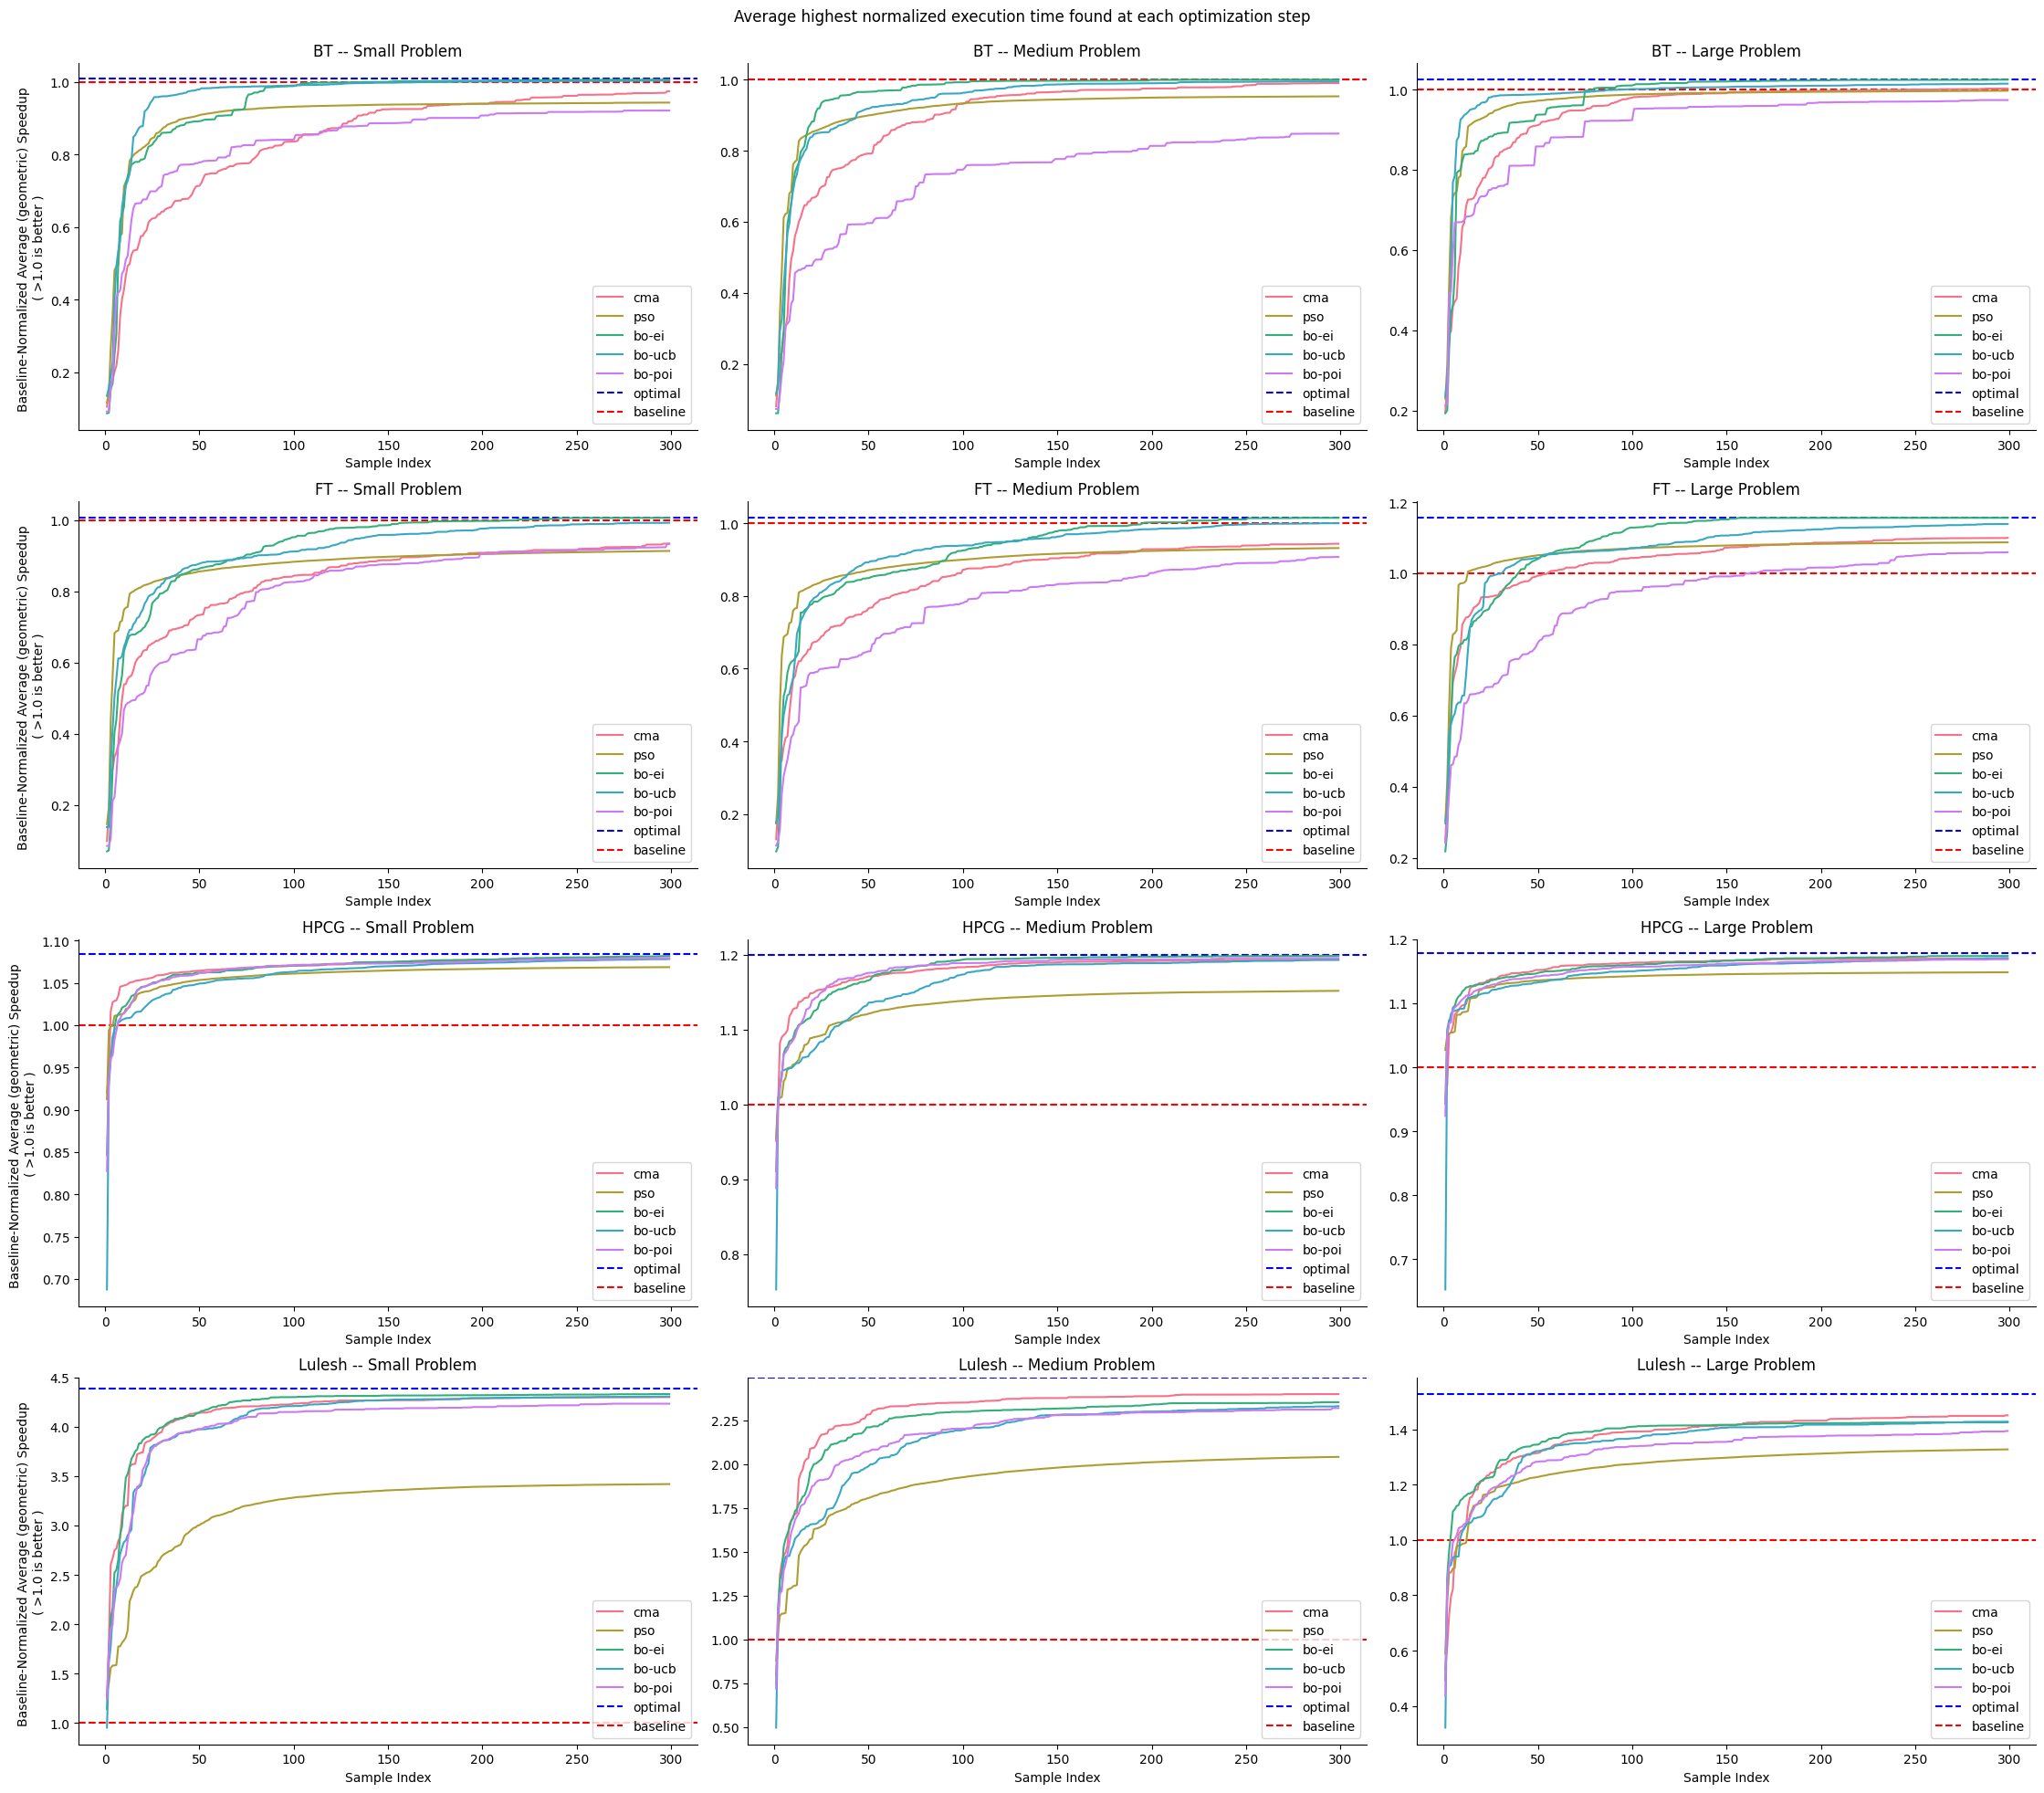

In [10]:
baselinesDF = xtimeDB[(xtimeDB['OMP_NUM_THREADS'] == numthreads) 
										& (xtimeDB['OMP_PROC_BIND'] == 'close')
										& (xtimeDB['OMP_PLACES'] == 'cores')
										& (xtimeDB['OMP_SCHEDULE'] == 'static')]

def normToMinMax(row):
	progname = row['progname']
	probsize = row['probsize']

	minVal, maxVal = getMinMaxXtimeForProg(progname, probsize)

	row['xtime'] = 1 - (row['xtime']-minVal)/(maxVal-minVal)
	return row


# normalize the baselinesDF to the min/max
baselinesDF.loc[:,'xtime'] = baselinesDF.apply(normToMinMax, axis=1)['xtime']

if useBaseline:
	makeOverallPlots(overallDF, logscale=False)
	#makeOverallPlots(overallDF, logscale=False, useSeed=9999)
else:
	makeOverallPlots(overallDF,baselinesDF)